In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
NOISE_DIM = 128 # 64 in Gitlab
TESTING= False
BATCH_SIZE = 64
SAMPLE_SIZE= 50000
BINS = 25

In [3]:
filenames = {
    "herwig": "../GAN-data/events_anomalydetection_DelphesHerwig_qcd_features.h5",
    "pythiabg": "../GAN-data/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "../GAN-data/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]

train_features = ["ptj1", "etaj1", "mj1", "ptj2", "etaj2", "phij2", "mj2", "tau21j1", "tau21j2"]
condition_features = ["mjj"]

features = train_features + condition_features
GEN_DIM = NOISE_DIM + len(condition_features)
DISC_DIM = len(features)

In [4]:
def cut_data(uncut_data, pTmin = 1200, etamax = 2.5):
    # Column 0: ptj1
    # Column 1: etaj1
    # Column 3: ptj2
    # Column 4: etaj2
    return uncut_data[((uncut_data[:,0] > pTmin) & (np.abs(uncut_data[:,1]) < etamax)) | ((uncut_data[:,3] > pTmin) & (np.abs(uncut_data[:,4]) < etamax))]

np_bg_SB = np.load('./data/np_bg_SB.npy')
np_bg_SR = np.load('./data/np_bg_SR.npy')
np_sig_SR = np.load('./data/np_sig_SR.npy')

np_sig_SR_labeled = np.copy(np_sig_SR)
np_bg_SR_labeled = np.copy(np_bg_SR)

np_sig_SR_labeled = np.append(np_sig_SR_labeled,np.ones([len(np_sig_SR),1]),1)
np_bg_SR_labeled = np.append(np_bg_SR_labeled,np.zeros([len(np_bg_SR),1]),1)
np_combined_SR = np.concatenate((np_bg_SR, np_sig_SR), axis = 0)
np_combined_SR_labeled = np.concatenate((np_sig_SR_labeled,np_bg_SR_labeled),axis=0)

gc.collect()

9

In [5]:
np_sig_SR.shape[0]/np_bg_SR.shape[0]

0.6205640442400567

In [6]:
gen_model = tf.keras.models.load_model('./Results/epoch1000-generator.h5')

In [7]:
def generate_gan(generator, realdata):


    labels = sample_fake(refdata = realdata, size = SAMPLE_SIZE) # Sample mjj from the existing distribution of mjj for comparison
    labels_scaled = scaler_mjj.transform(labels.reshape(-1,1))
    
    fakedata_uncut_unscaled = generator(tf.concat([tf.random.uniform((SAMPLE_SIZE, NOISE_DIM)), labels_scaled], 1), training=False)
    fakedata_uncut = np.concatenate((scaler.inverse_transform(fakedata_uncut_unscaled), labels.reshape(-1,1)), axis = 1)
   

    # At least one jet has pT > 1200 and |eta| < 2.5
    fakedata = cut_data(fakedata_uncut)

    # mjj = sqrt(Ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
    fakedata_mjj = mjj(fakedata)

    return fakedata

In [8]:
def mjj(output):
    pt1 = output[:,0]
    eta1 = output[:,1]
    m1 = output[:,2]
    pt2 = output[:,3]
    eta2 = output[:,4]
    phi2 = output[:,5]
    m2 = output[:,6]
    ejj = np.sqrt((pt1 * np.cosh(eta1))**2 + m1**2) + np.sqrt((pt2 * np.cosh(eta2))**2 + m2**2)
    pxjj = pt1 + pt2 * np.cos(phi2)
    pyjj = pt2 * np.sin(phi2)
    pzjj = pt1 * np.sinh(eta1) + pt2 * np.sinh(eta2)
    return np.sqrt(ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)

In [9]:
def sample_fake(refdata = np_bg_SR, size = BATCH_SIZE):
    rand_idx = np.random.choice(refdata.shape[0], size = size)
    return refdata[rand_idx, -1].reshape((-1,1))

In [10]:
def sample_data(refdata = np_combined_SR,size= 10000):
    rand_idx = np.random.choice(refdata.shape[0], size)
    return refdata[rand_idx, :]


In [11]:
real_data = sample_data(size=100000)

In [12]:
np_bg_SB_trimmed = np.delete(np_bg_SB, [i for i in range(np_bg_SB.shape[0] % (BATCH_SIZE * 4))], axis = 0)

# Normalize inputs between -1 and 1, mjj between 0 and 1
scaler = MinMaxScaler((-1,1)).fit(np_bg_SB_trimmed[:,:-1])
scaler_mjj = MinMaxScaler((0,1)).fit(np_bg_SB_trimmed[:,-1].reshape(-1,1))
np_bg_SB_scaled = np.concatenate((scaler.transform(np_bg_SB_trimmed[:,:-1]), scaler_mjj.transform(np_bg_SB_trimmed[:,-1].reshape(-1,1))), axis = 1)

In [13]:
generated_data = generate_gan(gen_model,np_combined_SR)
generated_data2 = generate_gan(gen_model,np_combined_SR)
generated_data = np.concatenate((generated_data,generated_data2), axis = 0)
generated_data_labeled  = np.copy(generated_data)
generated_data_labeled = np.append(generated_data_labeled,np.zeros([len(generated_data_labeled),1]),1)


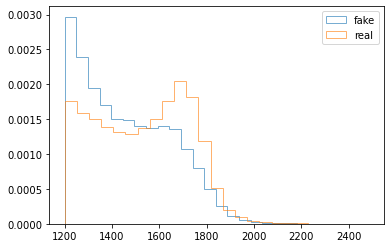

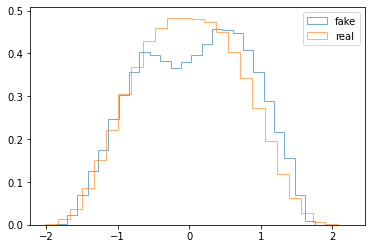

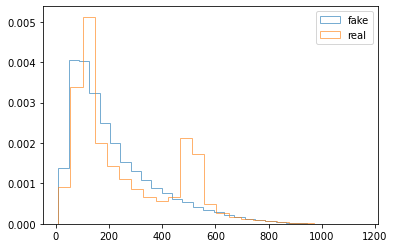

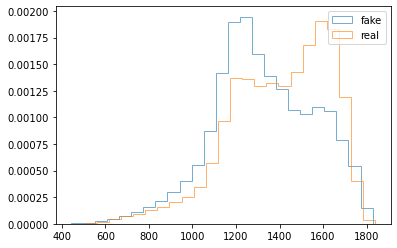

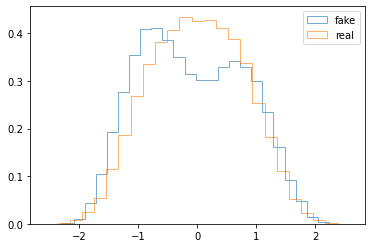

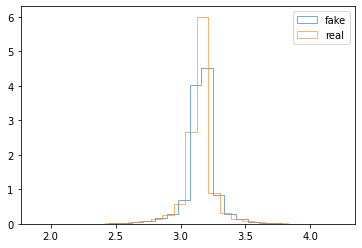

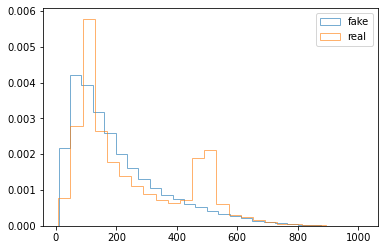

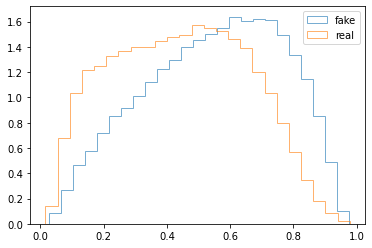

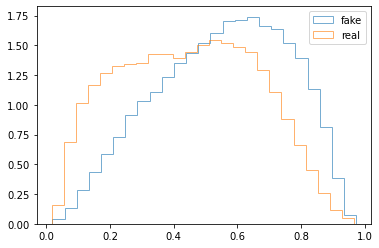

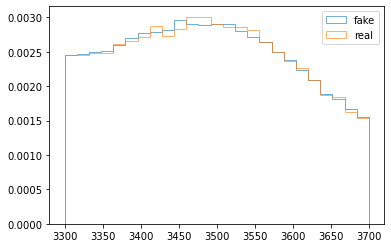

In [14]:
for i in range(0,10):
    plt.hist(generated_data[:,i],25,alpha=0.6,histtype = 'step',label = 'fake',density = True)
    plt.hist(real_data[:,i],25,alpha = 0.6,histtype = 'step',label = 'real',density = True)
    plt.legend()
    plt.show()

In [15]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      
]

In [16]:
def classifier_model():    
    model = tf.keras.Sequential()
    model.add(layers.Dense(64,input_dim = 9,activation ='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[METRICS])
    return model


In [17]:
classifier = classifier_model()
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4

In [18]:

def learningCurveLoss(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    #plt.ylim(0,5)
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('5_tag_learning_curve.png')
    plt.show()
    plt.close()
    #plt.savefig("Learning_Curve")

In [19]:
def plot_roc_curve(y_test, y_test_score):

    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    auc_value = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr,label=' AUC = %.1f%%'%(auc_value*100.))
    plt.plot([0, 1], [0, 1], 'k-')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    plt.show()

In [20]:
sb_ratio = np.logspace(-3,-0.205,5)
#sb_ratio = np.linspace(0,0.62,10)
mixedsb = []
generated_data = []
for i in sb_ratio:
    sampled_signal = np.random.choice(np_sig_SR.shape[0], (int)(i * np_bg_SR.shape[0]))
    combined = np.concatenate((np_sig_SR[sampled_signal,:],np_bg_SR), axis =0)
    gen = generate_gan(gen_model,combined)
    gen2 = generate_gan(gen_model,combined)
    gen_data = np.concatenate((gen,gen2),axis=0)
    generated_data.append(gen_data)
    mixedsb.append(sample_data(combined,size= 100000))

In [21]:
scaled_dataset = []
for i in range(len(mixedsb)):
    classifier_real = mixedsb[i][:,0:9] #4feature 2678
    classifier_fake = generated_data[i][:,0:9]
    unscaled_data = np.concatenate((classifier_real,classifier_fake),axis=0)
    scaler = StandardScaler().fit(unscaled_data)
    scaled_data = scaler.transform(unscaled_data)
    labels = np.concatenate((np.ones([len(classifier_real),1]),np.zeros([len(classifier_fake),1])),axis=0)
    scaled_dataset.append(np.concatenate((scaled_data,labels),axis=1))

In [22]:
scaled_dataset_arr_df = pd.DataFrame(scaled_dataset[0], columns = ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','label'])

In [23]:
scaled_dataset_arr_df

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,label
0,-0.378675,0.097453,0.490460,-0.091153,-1.290317,-0.050539,-0.637347,0.015939,0.548302,1.0
1,-1.146655,0.963058,0.048210,-2.406789,-1.675752,-4.341503,-0.616777,0.040302,-0.243908,1.0
2,-0.761316,-1.157641,1.830618,-0.850204,0.853290,0.873612,0.037681,-1.995163,0.479734,1.0
3,-1.379985,0.644119,-0.186871,-2.522165,-2.108006,-0.605694,-0.678393,0.241543,0.699978,1.0
4,-1.358181,0.349740,-0.887282,-0.796189,-1.682315,-0.285686,-0.460915,-1.250414,1.135666,1.0
...,...,...,...,...,...,...,...,...,...,...
199995,0.769864,1.199970,0.246955,0.992188,-0.155613,0.210322,-1.045072,-0.793416,1.757642,0.0
199996,-1.314728,-0.847873,-0.754257,-0.798050,1.513006,0.830353,-1.126220,0.850278,1.436041,0.0
199997,0.416602,0.545278,-0.042463,0.633501,-0.641070,0.673079,-0.622112,-0.986028,0.263029,0.0
199998,-0.558416,-0.373089,-0.639021,0.005178,-1.778638,-0.005030,-0.282918,0.359599,0.740203,0.0


In [24]:
print(generated_data[0].shape)
print(mixedsb[0].shape)
print(scaled_dataset[i].shape)
print(len(scaled_dataset))

(100000, 10)
(100000, 10)
(200000, 10)
5


Train on 120000 samples, validate on 40000 samples
Epoch 1/25
120000/120000 [==============================] - 5s 43us/sample - loss: 0.6590 - tp: 34900.0000 - fp: 22688.0000 - tn: 37337.0000 - fn: 25075.0000 - accuracy: 0.6020 - precision: 0.6060 - recall: 0.5819 - auc: 0.6453 - val_loss: 0.6366 - val_tp: 13675.0000 - val_fp: 8553.0000 - val_tn: 11634.0000 - val_fn: 6138.0000 - val_accuracy: 0.6327 - val_precision: 0.6152 - val_recall: 0.6902 - val_auc: 0.6881
Epoch 2/25
120000/120000 [==============================] - 3s 29us/sample - loss: 0.6355 - tp: 38174.0000 - fp: 22299.0000 - tn: 37726.0000 - fn: 21801.0000 - accuracy: 0.6325 - precision: 0.6313 - recall: 0.6365 - auc: 0.6892 - val_loss: 0.6222 - val_tp: 11652.0000 - val_fp: 5973.0000 - val_tn: 14214.0000 - val_fn: 8161.0000 - val_accuracy: 0.6467 - val_precision: 0.6611 - val_recall: 0.5881 - val_auc: 0.7091
Epoch 3/25
120000/120000 [==============================] - 3s 29us/sample - loss: 0.6243 - tp: 38677.0000 - fp: 20770.

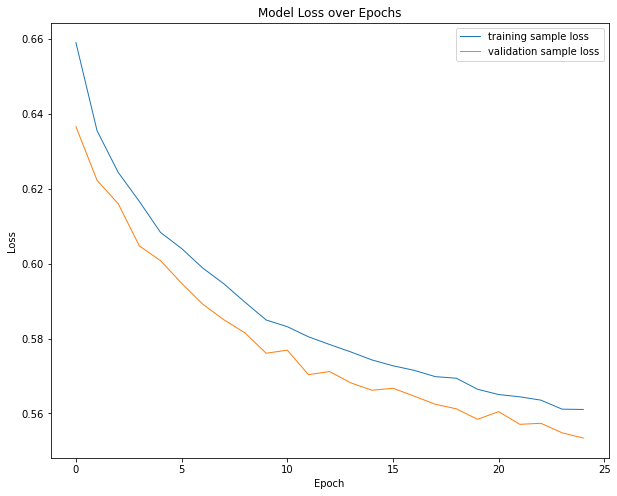

Train on 120000 samples, validate on 40000 samples
Epoch 1/25
120000/120000 [==============================] - 5s 45us/sample - loss: 0.6615 - tp: 34813.0000 - fp: 22830.0000 - tn: 37195.0000 - fn: 25162.0000 - accuracy: 0.6001 - precision: 0.6039 - recall: 0.5805 - auc: 0.6405 - val_loss: 0.6370 - val_tp: 13557.0000 - val_fp: 8378.0000 - val_tn: 11809.0000 - val_fn: 6256.0000 - val_accuracy: 0.6342 - val_precision: 0.6181 - val_recall: 0.6842 - val_auc: 0.6921
Epoch 2/25
120000/120000 [==============================] - 4s 30us/sample - loss: 0.6379 - tp: 37793.0000 - fp: 21952.0000 - tn: 38073.0000 - fn: 22182.0000 - accuracy: 0.6322 - precision: 0.6326 - recall: 0.6301 - auc: 0.6851 - val_loss: 0.6232 - val_tp: 12469.0000 - val_fp: 6744.0000 - val_tn: 13443.0000 - val_fn: 7344.0000 - val_accuracy: 0.6478 - val_precision: 0.6490 - val_recall: 0.6293 - val_auc: 0.7080
Epoch 3/25
120000/120000 [==============================] - 3s 29us/sample - loss: 0.6297 - tp: 38795.0000 - fp: 21817.

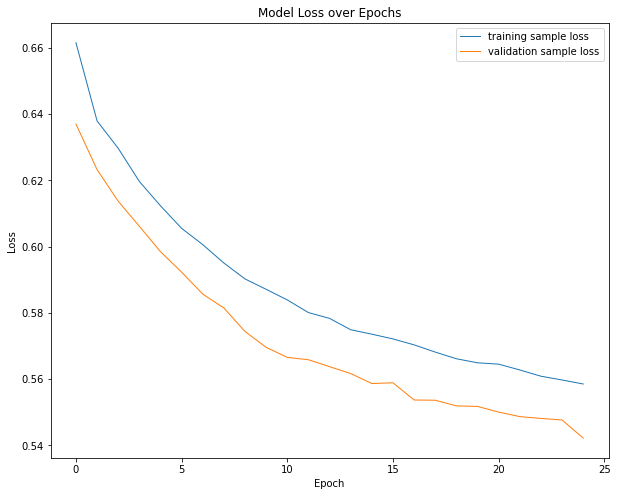

Train on 120000 samples, validate on 40000 samples
Epoch 1/25
120000/120000 [==============================] - 5s 45us/sample - loss: 0.6616 - tp: 35389.0000 - fp: 23660.0000 - tn: 36365.0000 - fn: 24586.0000 - accuracy: 0.5979 - precision: 0.5993 - recall: 0.5901 - auc: 0.6401 - val_loss: 0.6334 - val_tp: 11121.0000 - val_fp: 5906.0000 - val_tn: 14281.0000 - val_fn: 8692.0000 - val_accuracy: 0.6350 - val_precision: 0.6531 - val_recall: 0.5613 - val_auc: 0.6950
Epoch 2/25
120000/120000 [==============================] - 4s 31us/sample - loss: 0.6358 - tp: 38188.0000 - fp: 22287.0000 - tn: 37738.0000 - fn: 21787.0000 - accuracy: 0.6327 - precision: 0.6315 - recall: 0.6367 - auc: 0.6879 - val_loss: 0.6229 - val_tp: 13771.0000 - val_fp: 7919.0000 - val_tn: 12268.0000 - val_fn: 6042.0000 - val_accuracy: 0.6510 - val_precision: 0.6349 - val_recall: 0.6950 - val_auc: 0.7125
Epoch 3/25
120000/120000 [==============================] - 4s 31us/sample - loss: 0.6244 - tp: 38583.0000 - fp: 21214.

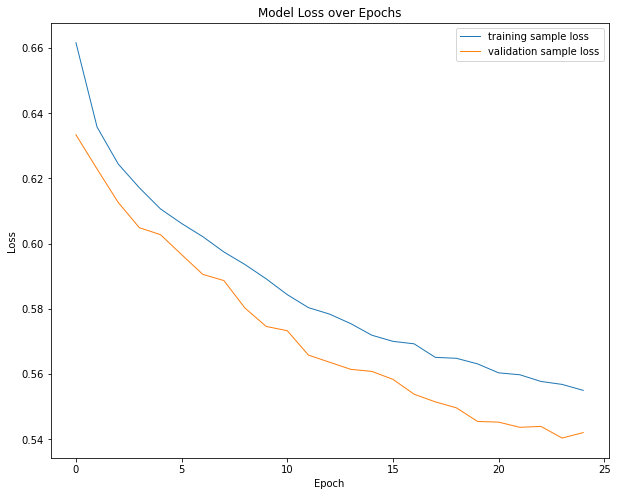

Train on 120000 samples, validate on 40000 samples
Epoch 1/25
120000/120000 [==============================] - 5s 45us/sample - loss: 0.6507 - tp: 33132.0000 - fp: 19513.0000 - tn: 40512.0000 - fn: 26843.0000 - accuracy: 0.6137 - precision: 0.6293 - recall: 0.5524 - auc: 0.6612 - val_loss: 0.6225 - val_tp: 11658.0000 - val_fp: 5843.0000 - val_tn: 14344.0000 - val_fn: 8155.0000 - val_accuracy: 0.6500 - val_precision: 0.6661 - val_recall: 0.5884 - val_auc: 0.7089
Epoch 2/25
120000/120000 [==============================] - 4s 30us/sample - loss: 0.6250 - tp: 36770.0000 - fp: 19548.0000 - tn: 40477.0000 - fn: 23205.0000 - accuracy: 0.6437 - precision: 0.6529 - recall: 0.6131 - auc: 0.7034 - val_loss: 0.6109 - val_tp: 13807.0000 - val_fp: 7642.0000 - val_tn: 12545.0000 - val_fn: 6006.0000 - val_accuracy: 0.6588 - val_precision: 0.6437 - val_recall: 0.6969 - val_auc: 0.7261
Epoch 3/25
120000/120000 [==============================] - 3s 29us/sample - loss: 0.6130 - tp: 37704.0000 - fp: 18817.

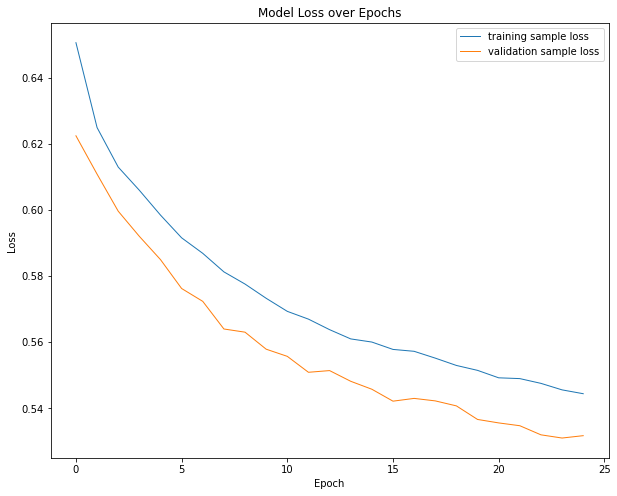

Train on 120000 samples, validate on 40000 samples
Epoch 1/25
120000/120000 [==============================] - 6s 47us/sample - loss: 0.5904 - tp: 32743.0000 - fp: 12061.0000 - tn: 47964.0000 - fn: 27232.0000 - accuracy: 0.6726 - precision: 0.7308 - recall: 0.5459 - auc: 0.7330 - val_loss: 0.5561 - val_tp: 11961.0000 - val_fp: 4062.0000 - val_tn: 16125.0000 - val_fn: 7852.0000 - val_accuracy: 0.7021 - val_precision: 0.7465 - val_recall: 0.6037 - val_auc: 0.7738
Epoch 2/25
120000/120000 [==============================] - 4s 31us/sample - loss: 0.5598 - tp: 36031.0000 - fp: 12393.0000 - tn: 47632.0000 - fn: 23944.0000 - accuracy: 0.6972 - precision: 0.7441 - recall: 0.6008 - auc: 0.7691 - val_loss: 0.5400 - val_tp: 12085.0000 - val_fp: 3755.0000 - val_tn: 16432.0000 - val_fn: 7728.0000 - val_accuracy: 0.7129 - val_precision: 0.7629 - val_recall: 0.6100 - val_auc: 0.7881
Epoch 3/25
120000/120000 [==============================] - 4s 31us/sample - loss: 0.5476 - tp: 37060.0000 - fp: 12263.

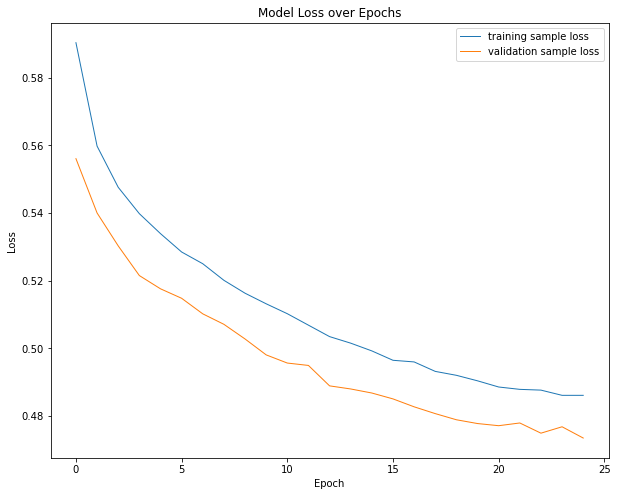

In [25]:
ypred = []
fp_c, tp_c,th_c= [],[],[]
auc_list_c = []
for i in range(len(scaled_dataset)): 
    x_train,x_test,y_train,y_test = train_test_split(scaled_dataset[i][:,0:9],scaled_dataset[i][:,-1], test_size = 0.2, random_state=1)
    x_train,x_val,y_train,y_val= train_test_split(x_train,y_train, test_size = 0.25, random_state=1)

    classifier = classifier_model()
    history = classifier.fit(x_train, y_train, epochs=25, batch_size=128,validation_data=(x_val,y_val))
    learningCurveLoss(history)
    y_pred = classifier.predict(x_test)
    ypred.append(y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = auc(fpr,tpr)
    auc_list_c.append(auc_value)
    fp_c.append(fpr)
    tp_c.append(tpr)
    th_c.append(thresholds)

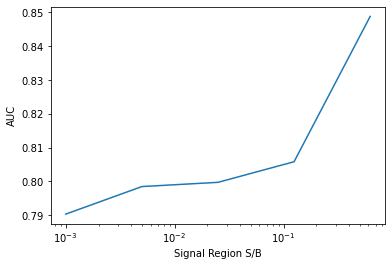

In [27]:
plt.plot(sb_ratio,auc_list_c)
plt.xlabel('Signal Region S/B')
plt.xscale('log')
plt.ylabel('AUC')
plt.savefig('AUC')

In [28]:
eff_ratio = []
for i in range(len(tp_c)):
    tp_c[i] = tp_c[i] + 0.0000001
    fp_c[i] = fp_c[i] + 0.0000001
    eff_ratio.append(max(tp_c[i]/np.sqrt(fp_c[i])))# * (sb_ratio[i] * np_bg_SR.shape[0])/(np.sqrt(np_bg_SR.shape[0])))
    


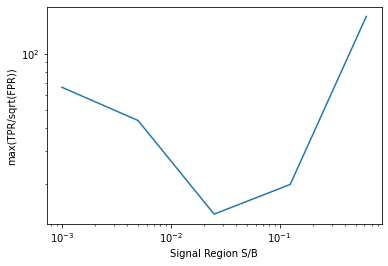

In [29]:
plt.plot(sb_ratio,eff_ratio)
plt.xlabel('Signal Region S/B')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('max(TPR/sqrt(FPR))')# * S/sqrt(B)')
plt.savefig('eff')

In [20]:
# double labeled dataset
sb_ratio = np.logspace(-3,-0.205,5)
mixedsb_labeled = []
generateddata_labeled = []
for i in sb_ratio:
    sampled_signal = np.random.choice(np_sig_SR.shape[0], (int)(i * np_bg_SR.shape[0]))
    combined = np.concatenate((np_sig_SR_labeled[sampled_signal,:],np_bg_SR_labeled), axis =0)
    generated_data = generate_gan(gen_model,np_combined_SR)
    generated_data2 = generate_gan(gen_model,np_combined_SR)
    generated_data = np.concatenate((generated_data,generated_data2), axis = 0)
    generated_data_labeled  = np.copy(generated_data)
    generated_data_labeled = np.append(generated_data_labeled,np.zeros([len(generated_data_labeled),1]),1)
    mixedsb_labeled.append(sample_data(combined,100000))
    generateddata_labeled.append(generated_data_labeled)

In [21]:
mixedsb_labeled[0][:,10]
unique, counts = np.unique(mixedsb_labeled[0][:,10], return_counts=True)
dict(zip(unique, counts))

{0.0: 99914, 1.0: 86}

In [22]:
scaled_dataset_labeled = []
for i in range(len(mixedsb_labeled)):
    classifier_real = mixedsb_labeled[i][:,0:9]#4feature 2678
    classifier_fake = generateddata_labeled[i][:,0:9]
    sblabel_real = mixedsb_labeled[i][:,10]
    sblabel_fake = generateddata_labeled[i][:,10]
    unscaled_data_labeled = np.concatenate((classifier_real,classifier_fake),axis=0)
    sblabel = np.concatenate((sblabel_real,sblabel_fake),axis = 0)
    scaler = StandardScaler().fit(unscaled_data_labeled)
    scaled_data = scaler.transform(unscaled_data_labeled)
    sblabel = sblabel.reshape(len(sblabel),1)
    labels = np.concatenate((np.ones([len(classifier_real),1]),np.zeros([len(classifier_fake),1])),axis=0)
    scaled_data = np.concatenate((scaled_data,sblabel),axis=1)
    scaled_dataset_labeled.append(np.concatenate((scaled_data,labels),axis=1))

In [23]:
scaled_dataset_label_df = pd.DataFrame(scaled_dataset_labeled[4], columns = ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','sblabel','rflabel'])

In [24]:
scaled_dataset_label_df 

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,sblabel,rflabel
0,-1.425756,-1.582287,0.095587,-1.640149,1.320569,0.110099,-1.331431,-1.013593,-0.324918,0.0,1.0
1,-0.933668,1.399835,0.714582,-0.691304,-0.598722,0.116964,-0.727024,0.306808,0.951861,0.0,1.0
2,-1.325555,1.660050,-1.174116,-2.108925,-1.180289,-1.493805,0.027007,0.826862,0.125200,0.0,1.0
3,-0.098710,0.879031,0.918668,-1.002841,-0.852557,-1.759039,-1.121819,0.045285,1.715314,0.0,1.0
4,0.973593,0.685242,1.641955,0.996380,0.034280,-0.350093,-0.602394,-1.075391,-0.652041,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
199995,-0.547032,1.236844,-1.078775,-1.449921,-1.237132,-2.065347,-1.062423,0.720656,0.663286,0.0,0.0
199996,-0.018234,1.177703,-0.407560,0.343596,-0.306142,-0.022214,1.914600,1.958091,-0.669544,0.0,0.0
199997,-0.703701,-1.106062,0.538917,-0.172126,0.974724,0.297202,-0.451841,0.538094,1.446978,0.0,0.0
199998,-0.896304,1.611474,1.177103,-1.844082,-0.948151,-2.426220,0.042287,-0.232556,0.826815,0.0,0.0


Train on 120000 samples, validate on 40000 samples
Epoch 1/20
120000/120000 [==============================] - 8s 68us/sample - loss: 0.6549 - tp: 35999.0000 - fp: 23267.0000 - tn: 36758.0000 - fn: 23976.0000 - accuracy: 0.6063 - precision: 0.6074 - recall: 0.6002 - auc: 0.6538 - val_loss: 0.6308 - val_tp: 14050.0000 - val_fp: 8762.0000 - val_tn: 11425.0000 - val_fn: 5763.0000 - val_accuracy: 0.6369 - val_precision: 0.6159 - val_recall: 0.7091 - val_auc: 0.6971
Epoch 2/20
120000/120000 [==============================] - 7s 55us/sample - loss: 0.6325 - tp: 38597.0000 - fp: 22070.0000 - tn: 37955.0000 - fn: 21378.0000 - accuracy: 0.6379 - precision: 0.6362 - recall: 0.6436 - auc: 0.6938 - val_loss: 0.6213 - val_tp: 12321.0000 - val_fp: 6458.0000 - val_tn: 13729.0000 - val_fn: 7492.0000 - val_accuracy: 0.6513 - val_precision: 0.6561 - val_recall: 0.6219 - val_auc: 0.7108
Epoch 3/20
120000/120000 [==============================] - 7s 54us/sample - loss: 0.6221 - tp: 39127.0000 - fp: 21295.

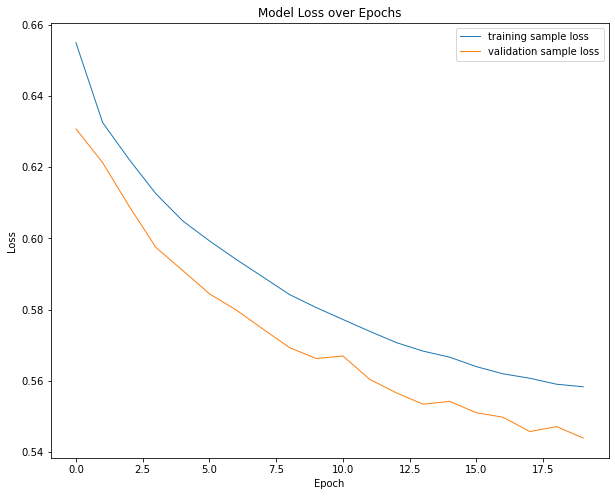

Train on 120000 samples, validate on 40000 samples
Epoch 1/20
120000/120000 [==============================] - 9s 71us/sample - loss: 0.6519 - tp: 36931.0000 - fp: 23675.0000 - tn: 36350.0000 - fn: 23044.0000 - accuracy: 0.6107 - precision: 0.6094 - recall: 0.6158 - auc: 0.6594 - val_loss: 0.6336 - val_tp: 14647.0000 - val_fp: 9461.0000 - val_tn: 10726.0000 - val_fn: 5166.0000 - val_accuracy: 0.6343 - val_precision: 0.6076 - val_recall: 0.7393 - val_auc: 0.6965
Epoch 2/20
120000/120000 [==============================] - 7s 55us/sample - loss: 0.6289 - tp: 38968.0000 - fp: 21846.0000 - tn: 38179.0000 - fn: 21007.0000 - accuracy: 0.6429 - precision: 0.6408 - recall: 0.6497 - auc: 0.6992 - val_loss: 0.6187 - val_tp: 11173.0000 - val_fp: 5280.0000 - val_tn: 14907.0000 - val_fn: 8640.0000 - val_accuracy: 0.6520 - val_precision: 0.6791 - val_recall: 0.5639 - val_auc: 0.7156
Epoch 3/20
120000/120000 [==============================] - 7s 56us/sample - loss: 0.6190 - tp: 39512.0000 - fp: 21007.

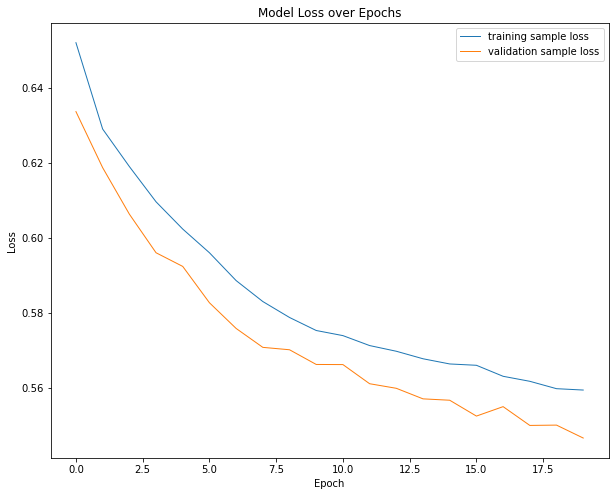

Train on 120000 samples, validate on 40000 samples
Epoch 1/20
120000/120000 [==============================] - 8s 68us/sample - loss: 0.6530 - tp: 36613.0000 - fp: 23257.0000 - tn: 36768.0000 - fn: 23362.0000 - accuracy: 0.6115 - precision: 0.6115 - recall: 0.6105 - auc: 0.6580 - val_loss: 0.6301 - val_tp: 13402.0000 - val_fp: 7859.0000 - val_tn: 12328.0000 - val_fn: 6411.0000 - val_accuracy: 0.6432 - val_precision: 0.6304 - val_recall: 0.6764 - val_auc: 0.7006
Epoch 2/20
120000/120000 [==============================] - 6s 54us/sample - loss: 0.6282 - tp: 38896.0000 - fp: 21786.0000 - tn: 38239.0000 - fn: 21079.0000 - accuracy: 0.6428 - precision: 0.6410 - recall: 0.6485 - auc: 0.6998 - val_loss: 0.6116 - val_tp: 13255.0000 - val_fp: 6789.0000 - val_tn: 13398.0000 - val_fn: 6558.0000 - val_accuracy: 0.6663 - val_precision: 0.6613 - val_recall: 0.6690 - val_auc: 0.7262
Epoch 3/20
120000/120000 [==============================] - 7s 55us/sample - loss: 0.6177 - tp: 39603.0000 - fp: 21014.

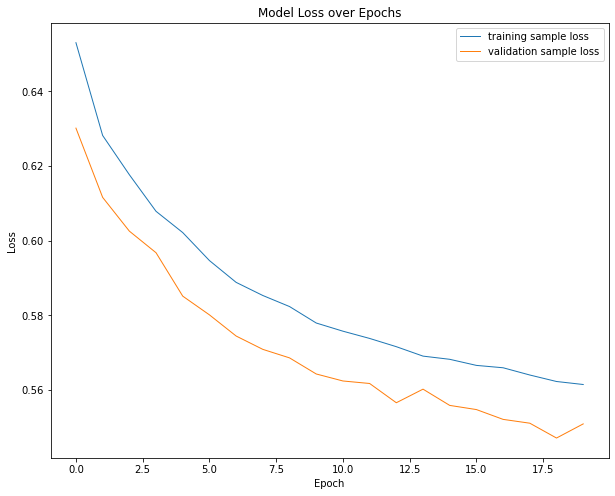

Train on 120000 samples, validate on 40000 samples
Epoch 1/20
120000/120000 [==============================] - 8s 69us/sample - loss: 0.6449 - tp: 35389.0000 - fp: 20941.0000 - tn: 39084.0000 - fn: 24586.0000 - accuracy: 0.6206 - precision: 0.6282 - recall: 0.5901 - auc: 0.6715 - val_loss: 0.6167 - val_tp: 12479.0000 - val_fp: 6603.0000 - val_tn: 13584.0000 - val_fn: 7334.0000 - val_accuracy: 0.6516 - val_precision: 0.6540 - val_recall: 0.6298 - val_auc: 0.7149
Epoch 2/20
120000/120000 [==============================] - 7s 55us/sample - loss: 0.6191 - tp: 37951.0000 - fp: 19902.0000 - tn: 40123.0000 - fn: 22024.0000 - accuracy: 0.6506 - precision: 0.6560 - recall: 0.6328 - auc: 0.7116 - val_loss: 0.6073 - val_tp: 11605.0000 - val_fp: 5234.0000 - val_tn: 14953.0000 - val_fn: 8208.0000 - val_accuracy: 0.6640 - val_precision: 0.6892 - val_recall: 0.5857 - val_auc: 0.7297
Epoch 3/20
120000/120000 [==============================] - 7s 55us/sample - loss: 0.6066 - tp: 39403.0000 - fp: 19713.

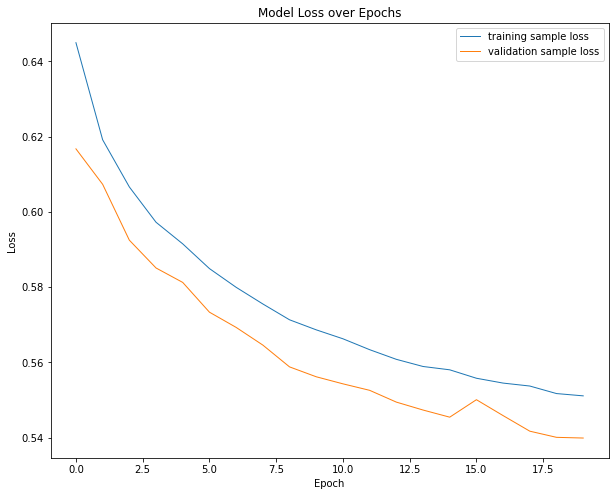

Train on 120000 samples, validate on 40000 samples
Epoch 1/20
120000/120000 [==============================] - 8s 70us/sample - loss: 0.5889 - tp: 32984.0000 - fp: 12061.0000 - tn: 47964.0000 - fn: 26991.0000 - accuracy: 0.6746 - precision: 0.7322 - recall: 0.5500 - auc: 0.7355 - val_loss: 0.5522 - val_tp: 11006.0000 - val_fp: 3029.0000 - val_tn: 17158.0000 - val_fn: 8807.0000 - val_accuracy: 0.7041 - val_precision: 0.7842 - val_recall: 0.5555 - val_auc: 0.7795
Epoch 2/20
120000/120000 [==============================] - 7s 55us/sample - loss: 0.5577 - tp: 36062.0000 - fp: 12094.0000 - tn: 47931.0000 - fn: 23913.0000 - accuracy: 0.6999 - precision: 0.7489 - recall: 0.6013 - auc: 0.7708 - val_loss: 0.5362 - val_tp: 12392.0000 - val_fp: 3713.0000 - val_tn: 16474.0000 - val_fn: 7421.0000 - val_accuracy: 0.7217 - val_precision: 0.7695 - val_recall: 0.6254 - val_auc: 0.7963
Epoch 3/20
120000/120000 [==============================] - 7s 55us/sample - loss: 0.5437 - tp: 36721.0000 - fp: 11581.

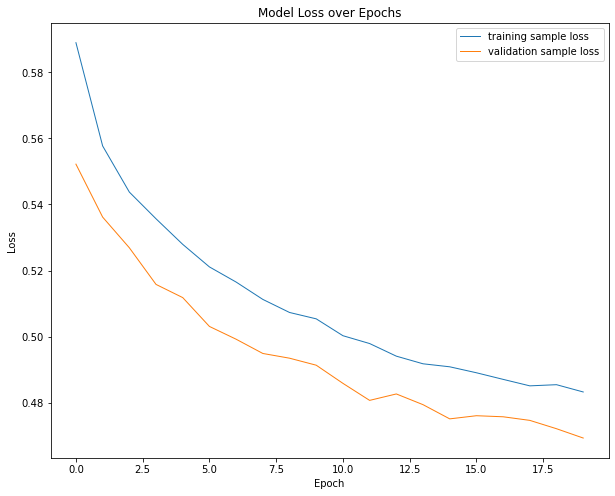

In [25]:
ypred_labeled = []
fp_cl, tp_cl,th_cl= [],[],[]
auc_list_cl = []
for i in range(len(scaled_dataset_labeled)): 
    x_train,x_test,y_train,y_test = train_test_split(scaled_dataset_labeled[i][:,0:9],scaled_dataset_labeled[i][:,-1], test_size = 0.2, random_state=1)
    _,_,sby_train,sby_test = train_test_split(scaled_dataset_labeled[i][:,0:9],scaled_dataset_labeled[i][:,-2], test_size = 0.2, random_state=1)
    x_train,x_val,y_train,y_val= train_test_split(x_train,y_train, test_size = 0.25, random_state=1)
    _,_,sby_train,sby_val = train_test_split(scaled_dataset_labeled[i][:,0:9],scaled_dataset_labeled[i][:,-2], test_size = 0.2, random_state=1)

    classifier = classifier_model()
    history = classifier.fit(x_train, y_train, epochs=20, batch_size=64,validation_data=(x_val,y_val))
    learningCurveLoss(history)
    y_pred = classifier.predict(x_test)
    ypred_labeled.append(y_pred)
    fpr, tpr, thresholds = roc_curve(sby_test, y_pred)
    auc_value = auc(fpr,tpr)
    auc_list_cl.append(auc_value)
    fp_cl.append(fpr)
    tp_cl.append(tpr)
    th_cl.append(thresholds)

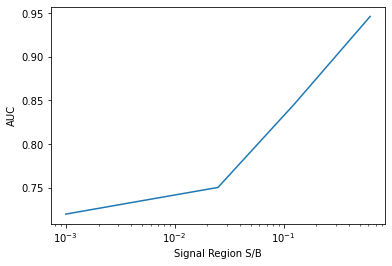

In [41]:
plt.plot(sb_ratio,auc_list_cl)
plt.xlabel('Signal Region S/B')
plt.xscale('log')
plt.ylabel('AUC')
plt.savefig('AUC')

In [27]:
eff_ratiol = []
for i in range(len(tp_cl)):
    tp_cl[i] = tp_cl[i] + 0.0000001
    fp_cl[i] = fp_cl[i] + 0.0000001
    eff_ratiol.append(max(tp_cl[i]/np.sqrt(fp_cl[i])))# * (sb_ratio[i] * np_bg_SR.shape[0])/(np.sqrt(np_bg_SR.shape[0])))
    

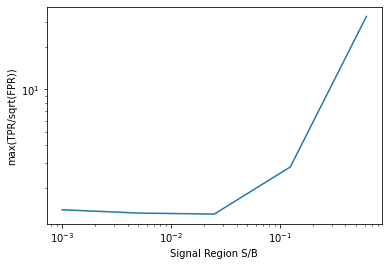

In [28]:
plt.plot(sb_ratio,eff_ratiol)
plt.xlabel('Signal Region S/B')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('max(TPR/sqrt(FPR))')# * S/sqrt(B)')
plt.savefig('eff')

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics 


In [30]:
ypred_tree = []
fpt, tpt,tht= [],[],[]
auc_listt = []

for i in range(len(scaled_dataset_labeled)): 
    x_train,x_test,y_train,y_test = train_test_split(scaled_dataset_labeled[i][:,0:9],scaled_dataset_labeled[i][:,-1], test_size = 0.2, random_state=1)
    _,_,sby_train,sby_test = train_test_split(scaled_dataset_labeled[i][:,0:9],scaled_dataset_labeled[i][:,-2], test_size = 0.2, random_state=1)
    x_train,x_val,y_train,y_val= train_test_split(x_train,y_train, test_size = 0.25, random_state=1)
    _,_,sby_train,sby_val = train_test_split(scaled_dataset_labeled[i][:,0:9],scaled_dataset_labeled[i][:,-2], test_size = 0.2, random_state=1)

    clf = DecisionTreeClassifier()
    clf = clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    ypred_tree.append(y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = auc(fpr,tpr)
    auc_listt.append(auc_value)
    fpt.append(fpr)
    tpt.append(tpr)
    tht.append(thresholds)

In [35]:
dteff_ratio = []
for i in range(len(tpt)):
    tpt[i] = tpt[i] + 0.0000001
    fpt[i] = fpt[i] + 0.0000001
    dteff_ratio.append(max(tp_cl[i]/np.sqrt(fp_cl[i])))# * (sb_ratio[i] * np_bg_SR.shape[0])/(np.sqrt(np_bg_SR.shape[0])))

Text(0, 0.5, 'max(TPR/sqrt(FPR))')

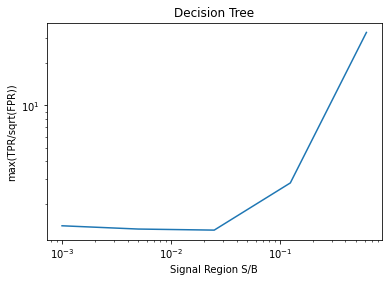

In [40]:
plt.plot(sb_ratio,dteff_ratio)
plt.title("Decision Tree")
plt.yscale('log')
plt.xlabel('Signal Region S/B')
plt.xscale('log')
plt.ylabel('max(TPR/sqrt(FPR))') #* S/sqrt(B))

Text(0, 0.5, 'AUC')

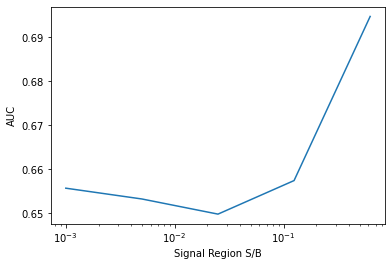

In [38]:
plt.plot(sb_ratio,auc_listt)
plt.xlabel('Signal Region S/B')
plt.xscale('log')
plt.ylabel('AUC')

In [ ]:
def classifier_model_4features():    
    model = tf.keras.Sequential()
    model.add(layers.Dense(64,input_dim = 4,activation ='relu'))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[METRICS])
    return model

In [ ]:
generated_data = generate_gan(gen_model)
generated_data2 = generate_gan(gen_model)
generated_data = np.concatenate((generated_data,generated_data2), axis = 0)
classifier_real = real_data[:,[2,6,7,8]]
classifier_fake = generated_data[:,[2,6,7,8]]
classifier_real = np.append(classifier_real,np.ones([len(classifier_real),1]),1)
classifier_fake = np.append(classifier_fake,np.zeros([len(classifier_fake),1]),1)
dataset = np.concatenate((classifier_real,classifier_fake),axis=0)
x_train,x_test,y_train,y_test = train_test_split(dataset[:,0:4],dataset[:,-1], test_size = 0.2, random_state=42)
x_train,x_val,y_train,y_val= train_test_split(dataset[:,0:4],dataset[:,-1], test_size = 0.2, random_state=42)

In [172]:
four_classifier= classifier_model_4features()
history = four_classifier.fit(x_train, y_train, epochs=20, batch_size=128,validation_data=(x_val,y_val))

Train on 160000 samples, validate on 40000 samples
Epoch 1/20
160000/160000 [==============================] - 5s 32us/sample - loss: 0.7263 - tp: 41344.0000 - fp: 26957.0000 - tn: 53036.0000 - fn: 38663.0000 - accuracy: 0.5899 - precision: 0.6053 - recall: 0.5168 - auc: 0.6159 - val_loss: 0.6696 - val_tp: 13595.0000 - val_fp: 10226.0000 - val_tn: 9781.0000 - val_fn: 6398.0000 - val_accuracy: 0.5844 - val_precision: 0.5707 - val_recall: 0.6800 - val_auc: 0.6554
Epoch 2/20
160000/160000 [==============================] - 4s 23us/sample - loss: 0.6644 - tp: 39365.0000 - fp: 21751.0000 - tn: 58242.0000 - fn: 40642.0000 - accuracy: 0.6100 - precision: 0.6441 - recall: 0.4920 - auc: 0.6408 - val_loss: 0.6469 - val_tp: 8225.0000 - val_fp: 3134.0000 - val_tn: 16873.0000 - val_fn: 11768.0000 - val_accuracy: 0.6274 - val_precision: 0.7241 - val_recall: 0.4114 - val_auc: 0.6517
Epoch 3/20
160000/160000 [==============================] - 4s 23us/sample - loss: 0.6495 - tp: 38325.0000 - fp: 19414.

In [185]:
sb_ratio = np.logspace(-3,-0.205,5)
#sb_ratio = np.linspace(0,0.62,10)
mixedsb = []
generated_data = []
for i in sb_ratio:
    sampled_signal = np.random.choice(np_sig_SR.shape[0], (int)(i * np_bg_SR.shape[0]))
    combined = np.concatenate((np_sig_SR[sampled_signal,:],np_bg_SR), axis =0)
    gen = generate_gan(gen_model)
    gen2 = generate_gan(gen_model)
    generated_data.append(np.concatenate((gen,gen2), axis = 0))
    mixedsb.append(sample_data(combined,size= 100000))

In [187]:
#generated_data[0].shape
generated_data[0].shape

(100000, 10)

Train on 160000 samples, validate on 40000 samples
Epoch 1/20
160000/160000 [==============================] - 5s 33us/sample - loss: 0.7657 - tp: 40865.0000 - fp: 39987.0000 - tn: 40006.0000 - fn: 39142.0000 - accuracy: 0.5054 - precision: 0.5054 - recall: 0.5108 - auc: 0.5065 - val_loss: 0.7678 - val_tp: 64.0000 - val_fp: 39.0000 - val_tn: 19968.0000 - val_fn: 19929.0000 - val_accuracy: 0.5008 - val_precision: 0.6214 - val_recall: 0.0032 - val_auc: 0.5083
Epoch 2/20
160000/160000 [==============================] - 4s 23us/sample - loss: 0.7169 - tp: 40635.0000 - fp: 39393.0000 - tn: 40600.0000 - fn: 39372.0000 - accuracy: 0.5077 - precision: 0.5078 - recall: 0.5079 - auc: 0.5080 - val_loss: 0.6965 - val_tp: 10733.0000 - val_fp: 10077.0000 - val_tn: 9930.0000 - val_fn: 9260.0000 - val_accuracy: 0.5166 - val_precision: 0.5158 - val_recall: 0.5368 - val_auc: 0.5201
Epoch 3/20
160000/160000 [==============================] - 4s 23us/sample - loss: 0.7026 - tp: 41305.0000 - fp: 39629.0000

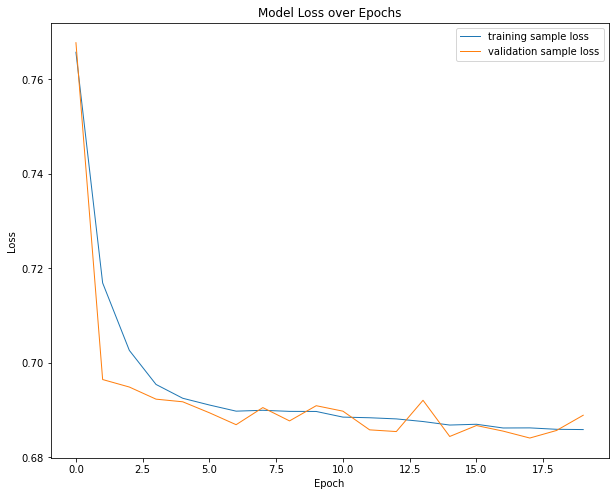

Train on 160000 samples, validate on 40000 samples
Epoch 1/20
160000/160000 [==============================] - 5s 33us/sample - loss: 0.8252 - tp: 41097.0000 - fp: 40191.0000 - tn: 39802.0000 - fn: 38910.0000 - accuracy: 0.5056 - precision: 0.5056 - recall: 0.5137 - auc: 0.5057 - val_loss: 0.7348 - val_tp: 6120.0000 - val_fp: 6352.0000 - val_tn: 13655.0000 - val_fn: 13873.0000 - val_accuracy: 0.4944 - val_precision: 0.4907 - val_recall: 0.3061 - val_auc: 0.4944
Epoch 2/20
160000/160000 [==============================] - 4s 23us/sample - loss: 0.7237 - tp: 40008.0000 - fp: 38842.0000 - tn: 41151.0000 - fn: 39999.0000 - accuracy: 0.5072 - precision: 0.5074 - recall: 0.5001 - auc: 0.5086 - val_loss: 0.6968 - val_tp: 3773.0000 - val_fp: 3270.0000 - val_tn: 16737.0000 - val_fn: 16220.0000 - val_accuracy: 0.5128 - val_precision: 0.5357 - val_recall: 0.1887 - val_auc: 0.5235
Epoch 3/20
160000/160000 [==============================] - 4s 23us/sample - loss: 0.7101 - tp: 41334.0000 - fp: 39221.

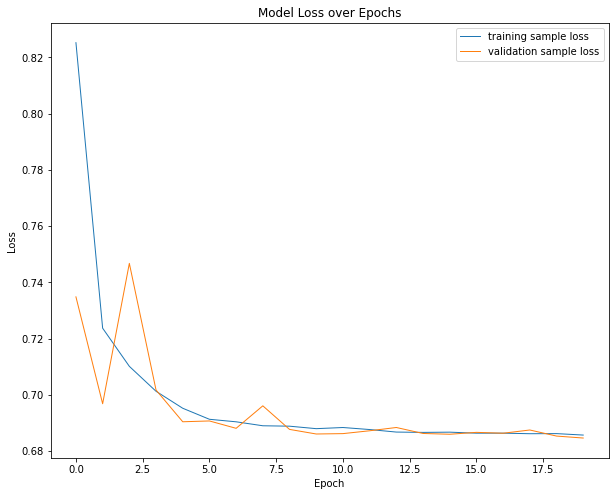

Train on 160000 samples, validate on 40000 samples
Epoch 1/20
160000/160000 [==============================] - 5s 33us/sample - loss: 0.7598 - tp: 39597.0000 - fp: 38450.0000 - tn: 41543.0000 - fn: 40410.0000 - accuracy: 0.5071 - precision: 0.5073 - recall: 0.4949 - auc: 0.5082 - val_loss: 0.6996 - val_tp: 6248.0000 - val_fp: 6191.0000 - val_tn: 13816.0000 - val_fn: 13745.0000 - val_accuracy: 0.5016 - val_precision: 0.5023 - val_recall: 0.3125 - val_auc: 0.5010
Epoch 2/20
160000/160000 [==============================] - 4s 23us/sample - loss: 0.7127 - tp: 38368.0000 - fp: 36816.0000 - tn: 43177.0000 - fn: 41639.0000 - accuracy: 0.5097 - precision: 0.5103 - recall: 0.4796 - auc: 0.5118 - val_loss: 0.6923 - val_tp: 12719.0000 - val_fp: 11875.0000 - val_tn: 8132.0000 - val_fn: 7274.0000 - val_accuracy: 0.5213 - val_precision: 0.5172 - val_recall: 0.6362 - val_auc: 0.5303
Epoch 3/20
160000/160000 [==============================] - 4s 23us/sample - loss: 0.7004 - tp: 38992.0000 - fp: 36844.

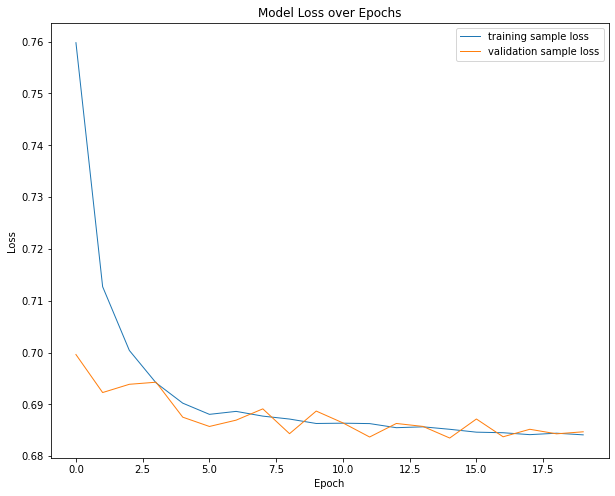

Train on 160000 samples, validate on 40000 samples
Epoch 1/20
160000/160000 [==============================] - 6s 36us/sample - loss: 0.7433 - tp: 37954.0000 - fp: 34983.0000 - tn: 45010.0000 - fn: 42053.0000 - accuracy: 0.5185 - precision: 0.5204 - recall: 0.4744 - auc: 0.5260 - val_loss: 0.6950 - val_tp: 10148.0000 - val_fp: 9229.0000 - val_tn: 10778.0000 - val_fn: 9845.0000 - val_accuracy: 0.5232 - val_precision: 0.5237 - val_recall: 0.5076 - val_auc: 0.5497
Epoch 2/20
160000/160000 [==============================] - 4s 23us/sample - loss: 0.7023 - tp: 36491.0000 - fp: 32337.0000 - tn: 47656.0000 - fn: 43516.0000 - accuracy: 0.5259 - precision: 0.5302 - recall: 0.4561 - auc: 0.5395 - val_loss: 0.7095 - val_tp: 1844.0000 - val_fp: 1108.0000 - val_tn: 18899.0000 - val_fn: 18149.0000 - val_accuracy: 0.5186 - val_precision: 0.6247 - val_recall: 0.0922 - val_auc: 0.5434
Epoch 3/20
160000/160000 [==============================] - 4s 23us/sample - loss: 0.6913 - tp: 34359.0000 - fp: 29277.

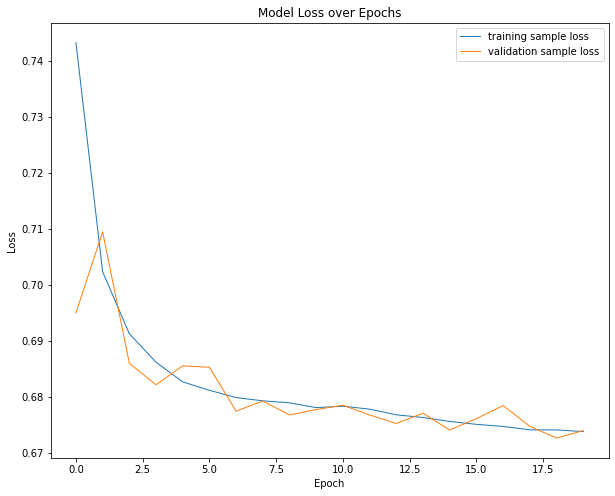

Train on 160000 samples, validate on 40000 samples
Epoch 1/20
160000/160000 [==============================] - 5s 32us/sample - loss: 0.7201 - tp: 41828.0000 - fp: 27449.0000 - tn: 52544.0000 - fn: 38179.0000 - accuracy: 0.5898 - precision: 0.6038 - recall: 0.5228 - auc: 0.6183 - val_loss: 0.6664 - val_tp: 11097.0000 - val_fp: 6827.0000 - val_tn: 13180.0000 - val_fn: 8896.0000 - val_accuracy: 0.6069 - val_precision: 0.6191 - val_recall: 0.5550 - val_auc: 0.6472
Epoch 2/20
160000/160000 [==============================] - 4s 23us/sample - loss: 0.6669 - tp: 40623.0000 - fp: 22804.0000 - tn: 57189.0000 - fn: 39384.0000 - accuracy: 0.6113 - precision: 0.6405 - recall: 0.5077 - auc: 0.6421 - val_loss: 0.6566 - val_tp: 10128.0000 - val_fp: 5477.0000 - val_tn: 14530.0000 - val_fn: 9865.0000 - val_accuracy: 0.6165 - val_precision: 0.6490 - val_recall: 0.5066 - val_auc: 0.6494
Epoch 3/20
160000/160000 [==============================] - 4s 24us/sample - loss: 0.6485 - tp: 39395.0000 - fp: 19841.

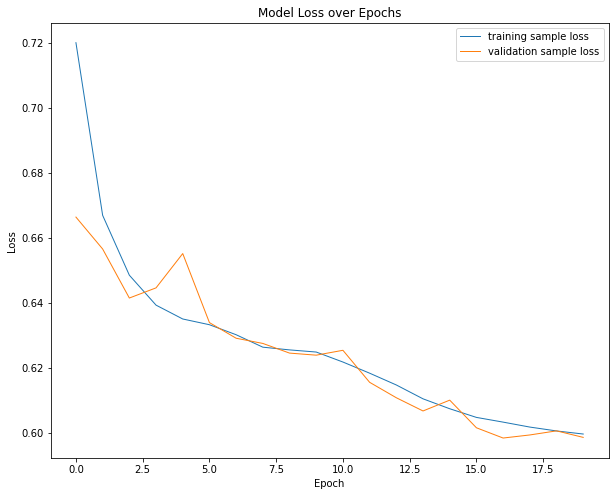

In [207]:
ypred4c = []
fp_4c, tp_4c,th_4c= [],[],[]
auc_list_4c = []
for i in range(len(mixedsb)): 
    classifier_real = mixedsb[i][:,[2,6,7,8]]
    classifier_fake = generated_data[i][:,[2,6,7,8]]
    
    real = np.append(classifier_real,np.ones([len(classifier_real),1]),1)
    fake = np.append(classifier_fake,np.zeros([len(classifier_fake),1]),1)
    dataset = np.concatenate((real,fake),axis=0)
    x_train,x_test,y_train,y_test = train_test_split(dataset[:,0:4],dataset[:,-1], test_size = 0.2, random_state=42)
    x_train,x_val,y_train,y_val= train_test_split(dataset[:,0:4],dataset[:,-1], test_size = 0.2, random_state=42)
    classifier = classifier_model_4features()
    history = classifier.fit(x_train, y_train, epochs=20, batch_size=128,validation_data=(x_val,y_val))
    learningCurveLoss(history)
    y_pred = classifier.predict(x_test)
    ypred4c.append(y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = auc(fpr,tpr)
    auc_list_4c.append(auc_value)
    fp_4c.append(fpr)
    tp_4c.append(tpr)
    th_4c.append(thresholds)
    

In [209]:
eff_ratio_4c = []
for i in range(len(tp_4c)):
    tp_4c[i] = tp_4c[i] + 0.0000001
    fp_4c[i] = fp_4c[i] + 0.0000001
    eff_ratio_4c.append(max(tp_4c[i]/np.sqrt(fp_4c[i])) * (sb_ratio[i] * np_bg_SR.shape[0])/(np.sqrt(np_bg_SR.shape[0])))

In [210]:
auc_list

5

Text(0, 0.5, 'AUC')

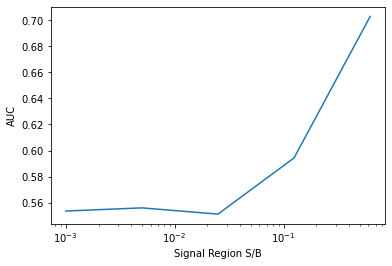

In [212]:
plt.plot(sb_ratio,auc_list_4c)
plt.xlabel('Signal Region S/B')
plt.xscale('log')
plt.ylabel('AUC')

Text(0, 0.5, 'max(TPR/sqrt(FPR)) * S/sqrt(B)')

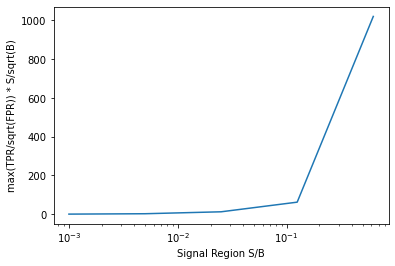

In [214]:
plt.plot(sb_ratio,eff_ratio_4c)
plt.xlabel('Signal Region S/B')
plt.xscale('log')
plt.ylabel('max(TPR/sqrt(FPR)) * S/sqrt(B)')

In [ ]:
# tpr, fpr, threshold. 